# TAREA 4: PERSONALIZACIÓN

<a id = "toc"></a>
# Índice
[Objetivos del notebook](#objetivos)

[Importación de las principales librerías](##import_modules)

[Importación de los datos](#import_data)


[Creación del dataset de personalización](#dataperson)


[Creación del pipline](#pipline)

[KMeans](#Knn)

[Presentación de resultados](#resultados)






<a id = "objetivos"></a>
# Objetivos del notebook
[Volver al índice](#toc)

En este notebook detallamos el proceso seguido para la segmentación de los 10000 clientes a los cuales se les ha recomendado la compra de algun producto en la anterior tarea con el objetivo de personalizar los mails en 4 o 5 creatividades distintias.


<a id = "import_modules"></a>
# Importación de las principales librerías
[Volver al índice](#toc)

In [ ]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")
# operating system
import os
# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd
# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

# python core library for machine learning and data science
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans 

from sklearn.externals import joblib 


RANDOM_STATE = 175
import os

from google.colab import drive


<a id = "import_data"></a>
# Importación de los datos
[Volver al índice](#toc)


In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


El primer archivo que importamos es el resultante de hacer la recomendación en la tarea 3. Asi pues este fichero contiene dos columnas:
- User_id: identificador del cliente
- target: producto a recomendar 

In [ ]:
df_recomend=pd.read_csv("gdrive/MyDrive/EASY_MONEY_NUCLIO/data/top_clients.csv",index_col=0)

In [ ]:
df_recomend.head()

,user_id,target
0,1459181,em_acount
1,1440380,em_acount
2,1465393,em_acount
3,1462014,em_acount
4,1423487,em_acount


Para poder añadir otros atributos que nos permitan personalizar los correos se carga tambien todo el dataset resultante de la primera segmentación el qual contiene ya algunas variables intersantes.

In [ ]:
df_tot=pd.read_pickle("gdrive/MyDrive/EASY_MONEY_NUCLIO/data/df_post_segmentacion_2.pkl")

In [ ]:
df_tot=df_tot.sort_values(by='pk_partition',ascending=False)

In [ ]:
df_tot.head().T

,5962923,5667597,5667586,5667587,5667588
pk_cid,1550586,1489272,1489286,1489285,1489283
pk_partition,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0
funds,0,0,0,0,0
securities,0,0,0,0,0
long_term_deposit,0,0,0,0,0
em_account_pp,0,0,0,0,0
credit_card,0,0,0,0,0


Para enriquecer nuestro modelo de personalización se han buscado en fuente externa (INE)  los siguientes datos: 
- La renta per capita por provincia.
- Población por provincia. 
- Tasa de actividad por provinica 
- IPC por provinicia. 

In [ ]:
df_renta=pd.read_excel("gdrive/MyDrive/EASY_MONEY_NUCLIO/data/renta.xlsx")

In [ ]:
df_renta.head()

,Provincia,Renta per cápita
0,Álava,36.404
1,Madrid,35.091
2,Guipuzcoa,33.851
3,Vizcaya,31.792
4,Navarra,31.026


In [ ]:
regions_code = {1:['Álava', 'País Vasco'], 2:['Albacete', 'Castilla-La Mancha'], 3:['Alicante', 'Com. Valenciana'],4:['Almería','Andalucía'],5:['Ávila','Castilla y León'], 6:['Badajoz','Extremadura'],
                        7:['Baleares','Islas Baleares'], 8:['Barcelona','Cataluña'],9:['Burgos','Castilla y León'], 10: ['Cáceres','Extremadura'], 11: ['Cádiz','Andalucía'], 12: ['Castellón','Com. Valenciana'],
                        13: ['Ciudad Real','Castilla-La Mancha'], 14: ['Córdoba','Andalucía'], 15: ['La Coruña','Galicia'], 16: ['Cuenca','Castilla-La Mancha'], 17: ['Gerona','Cataluña'], 18: ['Granada','Andalucía'],
                        19: ['Guadalajara','Castilla-La Mancha'], 20: ['Guipúzcoa','País Vasco'], 21: ['Huelva','Andalucía'], 22: ['Huesca','Aragón'], 23: ['Jaén','Andalucía'], 24: ['León','Castilla y León'],
                        25: ['Lérida','Cataluña'], 26: ['La Rioja','La Rioja'], 27: ['Lugo','Galicia'], 28: ['Madrid','Madrid'], 29: ['Málaga','Andalucía'], 30: ['Murcia','Murcia'], 31: ['Navarra','Com. de Navarra'],
                        32: ['Orense','Galicia'], 33: ['Asturias','Princ. de Asturias'], 34: ['Palencia','Castilla y León'], 35: ['Las Palmas','Islas Canarias'], 36: ['Pontevedra','Galicia'], 37: ['Salamanca','Castilla y León'],
                        38: ['Santa Cruz de Tenerife','Islas Canarias'], 39: ['Cantabria','Cantabria'], 40: ['Segovia','Castilla y León'], 41: ['Sevilla','Andalucía'], 42: ['Soria','Castilla y León'], 43: ['Tarragona','Cataluña'], 
                        44: ['Teruel','Aragón'], 45: ['Toledo','Castilla-La Mancha'], 46: ['Valencia','Com. Valenciana'], 47: ['Valladolid','Castilla y León'], 48: ['Vizcaya','País Vasco'], 49: ['Zamora','Castilla y León'], 
                        50: ['Zaragoza','Aragón'], 51: ['Ceuta','Ceuta y Melilla'], 52: ['Melilla','Ceuta y Melilla']}

In [ ]:
provincia={}
for key, val in regions_code.items():
    provincia[val[0]] = key 
df_renta['codigo']=df_renta['Provincia'].map(provincia)

In [ ]:
df_renta

,Provincia,Renta per cápita,codigo
0,Álava,36.404,1.0
1,Madrid,35.091,28.0
2,Guipuzcoa,33.851,NaN
3,Vizcaya,31.792,48.0
4,Navarra,31.026,31.0
5,Barcelona,30.947,8.0
6,Tarragona,30.810,43.0
7,Burgos,29.571,9.0
8,Lérida,28.456,25.0
9,Zaragoza,28.386,50.0


In [ ]:
del(df_renta['Provincia'])

In [ ]:
df_renta.columns=['Renta per cápita','region_code']

In [ ]:
df_poblacion=pd.read_csv("gdrive/MyDrive/EASY_MONEY_NUCLIO/data/poblacion_por_provincias.csv",sep=";")

In [ ]:
df_poblacion=df_poblacion[(df_poblacion['Sexo']=='Total') & (df_poblacion['Periodo']==2019)]

In [ ]:
df_poblacion=df_poblacion[(df_poblacion['Provincias']!='To') &(df_poblacion['Provincias']!='Total')]

In [ ]:
df_poblacion['Provincias']=df_poblacion['Provincias'].str.slice(start=0,stop=2).astype('float')

In [ ]:
df_poblacion.reset_index(drop=True,inplace=True)

In [ ]:
df_poblacion.drop(['Sexo','Periodo'],axis=1,inplace=True)

In [ ]:
df_poblacion.columns=['region_code','poblacion']

In [ ]:
df_poblacion

,region_code,poblacion
0,2.0,388.167
1,3.0,1.858.683
2,4.0,716.820
3,1.0,331.549
4,33.0,1.022.800
5,5.0,157.640
6,6.0,673.559
7,7.0,1.149.460
8,8.0,5.664.579
9,48.0,1.152.651


In [ ]:
df_tasa_actividad=pd.read_csv("gdrive/MyDrive/EASY_MONEY_NUCLIO/data/tasa_de_actividad.csv",sep=";")

In [ ]:
df_tasa_actividad=df_tasa_actividad[(df_tasa_actividad['Sexo']=='Ambos sexos')& (df_tasa_actividad['Provincias']!='Total Nacional') & (df_tasa_actividad['Periodo']=='2019T2') & (df_tasa_actividad['Tasas']=='Tasa de actividad')]

In [ ]:
df_tasa_actividad.drop(['Sexo','Tasas','Periodo'],axis=1,inplace=True)

In [ ]:
df_tasa_actividad['Provincias']=df_tasa_actividad['Provincias'].str.slice(start=0,stop=2).astype('float')

In [ ]:
df_tasa_actividad.reset_index(drop=True,inplace=True)

In [ ]:
df_tasa_actividad.columns=['region_code','Indice Actividad']

In [ ]:
df_IPC=pd.read_csv("gdrive/MyDrive/EASY_MONEY_NUCLIO/data/indice_IPC.csv",sep=";")

In [ ]:
df_IPC=df_IPC[(df_IPC['Comunidades y Ciudades Autónomas']!='Nacional')&(df_IPC['Grupos ECOICOP']=='Índice general')&(df_IPC['Tipo de dato']=='Índice')&(df_IPC['Periodo']=='2019M06')]

In [ ]:
df_IPC['Comunidades y Ciudades Autónomas']=df_IPC['Comunidades y Ciudades Autónomas'].str.slice(start=0,stop=2).astype('float')

In [ ]:
df_IPC.drop(['Grupos ECOICOP','Tipo de dato','Periodo'],axis=1,inplace=True)

In [ ]:
df_IPC.columns=['region_code','IPC']

In [ ]:
df_IPC.reset_index(drop=True,inplace=True)

In [ ]:
df_IPC

,region_code,IPC
0,1.0,"104,507"
1,2.0,"104,608"
2,3.0,"104,438"
3,4.0,"104,605"
4,5.0,"104,052"
5,6.0,"104,768"
6,7.0,"105,164"
7,8.0,"104,974"
8,9.0,"105,528"
9,10.0,"104,688"


### <a id = "dataperson"></a>
# Creación del dataset de personalización
[Volver al índice](#toc)

Basicamente queremos unir los tres dataframes cargados anteriormente de tal forma que obtengamos un dataset resultante con los 10000 clientes de los quales queremos personalizar el envio de correos y sus respectivos atributos. 

In [ ]:
df_tot=pd.merge(df_tot,df_renta,on='region_code',how='left')

In [ ]:
df_tot['Renta per cápita'].fillna(df_tot['Renta per cápita'].median(),inplace=True)

In [ ]:
df_tot=pd.merge(df_tot,df_poblacion,on='region_code',how='left')

In [ ]:
df_tot=pd.merge(df_tot,df_tasa_actividad,on='region_code',how='left')

In [ ]:
df_tot=pd.merge(df_tot,df_IPC,on='region_code',how='left')

In [ ]:
df_recomend.columns=['pk_cid','target']

In [ ]:
df_pers=pd.merge(df_recomend,df_tot,on='pk_cid',how='left').drop_duplicates(['pk_cid','target'],keep='first').reset_index(drop=True)

In [ ]:
df_pers.head()

,pk_cid,target,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,entry_date_year,entry_date_month,pk_partition_year,pk_partition_month,ConProducto,total_ahorro,total_inversion,total_financiacion,total_cuentas,EsEspañol,Num_cobros,Numero_bajas,Numero_altas,cluster,Renta per cápita,poblacion,Indice Actividad,IPC
0,1459181,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-09-30,KFC,0.0,02 - PARTICULARES,ES,35.0,1.0,19,0,NaN,2018,9,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,23.363,1.120.406,"60,18",NaN
1,1440380,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-08-31,KFC,0.0,02 - PARTICULARES,ES,21.0,1.0,23,0,57535.23,2018,8,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,20.273,521.870,"58,58",NaN
2,1465393,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-09-30,KFC,0.0,02 - PARTICULARES,ES,41.0,1.0,20,0,NaN,2018,9,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,20.314,1.942.389,"59,01",NaN
3,1462014,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-09-29,KFC,0.0,02 - PARTICULARES,ES,23.0,0.0,19,0,NaN,2018,9,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,18.628,633.564,"52,21",NaN
4,1423487,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-07-31,KHN,0.0,02 - PARTICULARES,ES,11.0,1.0,21,0,34419.45,2018,7,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,18.050,1.240.155,"55,33","104,39"


In [ ]:
df_pers.shape

(10000, 46)

In [ ]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print('El dataset tiene {} observaciones y {} columnas'.format(df.shape[0],df.shape[1]))
    print()
    print(f"Tenemos un total de {total_nulos} nulos")
    print()
    customer_id = df["pk_cid"].nunique()
    print(f'''Tenemos un total de {customer_id} clientes únicos''')

In [ ]:
report_df(df_pers)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pk_cid              10000 non-null  int64         
 1   target              10000 non-null  object        
 2   pk_partition        10000 non-null  datetime64[ns]
 3   short_term_deposit  10000 non-null  int64         
 4   loans               10000 non-null  int64         
 5   mortgage            10000 non-null  int64         
 6   funds               10000 non-null  int64         
 7   securities          10000 non-null  int64         
 8   long_term_deposit   10000 non-null  int64         
 9   em_account_pp       10000 non-null  int64         
 10  credit_card         10000 non-null  int64         
 11  payroll             10000 non-null  float64       
 12  pension_plan        10000 non-null  float64       
 13  payroll_account     10000 non-null  int64      

## Data Preparation

De toda esta información contenida solo nos quedaremos con aquella que nos permita hacer una personalización basada en los gustos o situación sociodemografica de los clientes. Se escogen los siguientes atributos, despues de realizar un proceso iterativo para la optimización del modelo. 

- Edad
- Salario 
- region_code 
- active_customer
- renta_per_cápita 
- Tasa de actividad
- Población 


In [ ]:
df_pers.set_index('pk_cid',inplace=True)

De todas las variables seleccionadas todas tienen un sentido ordinal excepto region_code. Es por eso que antes de segmentar se decide hacer un frequency encoding sobre esta variable. 

In [ ]:
fe=df_pers.groupby('region_code').size()/len(df_pers)

In [ ]:
df_pers['region_code'].fillna(method='bfill',inplace=True)

In [ ]:
df_pers['region_code_fe'] = df_pers['region_code'].apply(lambda x : fe[x] )

In [ ]:
df_pers.head()

,target,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,entry_date_year,entry_date_month,pk_partition_year,pk_partition_month,ConProducto,total_ahorro,total_inversion,total_financiacion,total_cuentas,EsEspañol,Num_cobros,Numero_bajas,Numero_altas,cluster,Renta per cápita,poblacion,Indice Actividad,IPC,region_code_fe
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1459181,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-09-30,KFC,0.0,02 - PARTICULARES,ES,35.0,1.0,19,0,NaN,2018,9,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,23.363,1.120.406,"60,18",NaN,0.0129
1440380,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-08-31,KFC,0.0,02 - PARTICULARES,ES,21.0,1.0,23,0,57535.23,2018,8,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,20.273,521.870,"58,58",NaN,0.0085
1465393,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-09-30,KFC,0.0,02 - PARTICULARES,ES,41.0,1.0,20,0,NaN,2018,9,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,20.314,1.942.389,"59,01",NaN,0.0386
1462014,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-09-29,KFC,0.0,02 - PARTICULARES,ES,23.0,0.0,19,0,NaN,2018,9,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,18.628,633.564,"52,21",NaN,0.0064
1423487,em_acount,2019-05-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2018-07-31,KHN,0.0,02 - PARTICULARES,ES,11.0,1.0,21,0,34419.45,2018,7,2019,5,0,0.0,0,0,0.0,1,0,0,0,NaN,18.050,1.240.155,"55,33","104,39",0.0151


In [ ]:
df_pers.drop('region_code',axis=1,inplace=True)

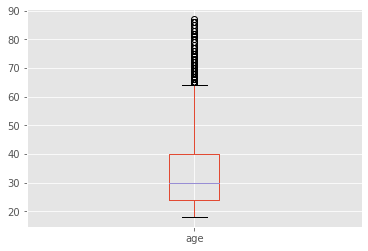

In [ ]:
df_pers['age'].plot(kind='box')

In [ ]:
df_pers['poblacion']=df_pers['poblacion'].str.replace('.','')

In [ ]:
df_pers['poblacion']=df_pers['poblacion'].astype('float')

In [ ]:
df_pers['Indice Actividad']=df_pers['Indice Actividad'].str.slice(start=0,stop=2).astype('float')

In [ ]:
df_pers['IPC']=df_pers['IPC'].str.replace(',','').str.slice(start=0,stop=5).astype('float')/100

In [ ]:
df_pers['IPC'].fillna(df_pers['IPC'].median(),inplace=True)

In [ ]:
needed_cols=['age','salary','region_code_fe','active_customer','Renta per cápita','poblacion','Indice Actividad'] # 'gender , 'IPC'
cols_to_drop=[c for c in df_pers if c not in needed_cols]
df_pers.drop(cols_to_drop,axis=1,inplace=True)

In [ ]:
columns = list(df_pers.columns)
index = list(df_pers.index)

In [ ]:
df_pers.isnull().sum()

active_customer        0
age                    0
salary              3593
Renta per cápita       0
poblacion              4
Indice Actividad       4
region_code_fe         0
dtype: int64

Ya tenemos el dataset como queriamos para poder hacer la segmentación. Ahora bien vemos la existencia de nulos en la columna de salario que hara falta tratar. Ademas en la columna de edad vimos en el EDA que existian muchos outilers que tendremos que tratar previamente para que no influencien negativamente en el modelo.

<a id = "pipline"></a>
# Creación del Pipline
[Volver al índice](#toc)



Con el objetivo de automatizar el proceso de personalización se crea un pipline que consta de los siguientes procesos:
- Imputación de nulos con KNN Imputer
- Limpiar outliers 
- Escalar los datos 
- Aplicar algoritimo Kmeans con la k optima ( previamente seleccionada)


In [ ]:
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

In [ ]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None): 
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

In [ ]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["age","salary"])),
    ("StandardScaler", StandardScaler())
])

In [ ]:
df_scaled_transformed_no_outliers = pipe.fit_transform(df_pers)

In [ ]:
CALCULATE_ELBOW = True

In [ ]:
if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 0 minutes.


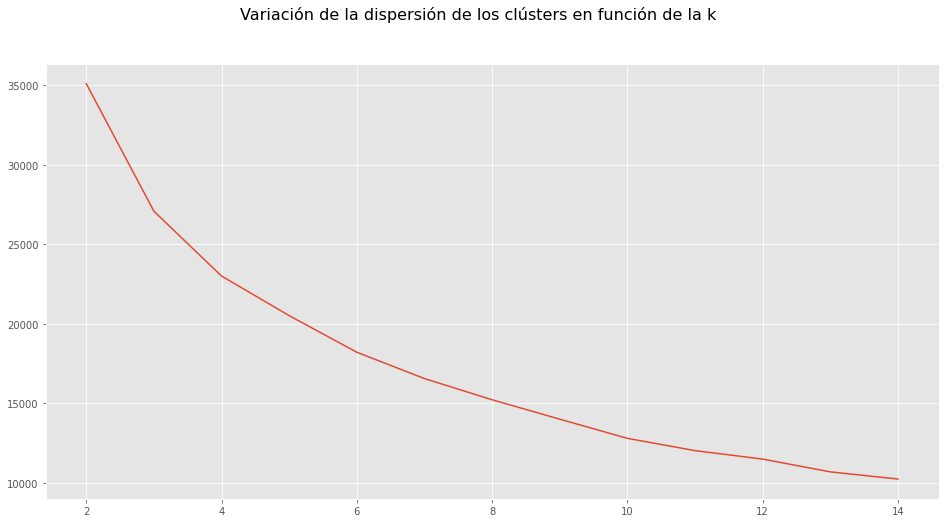

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

Observamos claramente como el numero de clusters optimo esta en k=4 ( cambio de pendiente más pronunciado). Es una gran noticia pues desde marketing nos pedian 4 o 5 creatividades. 

<a id = "Knn"></a>
# KMeans
[Volver al índice](#toc)


Una vez decidio que se crearan 5 creatividades distintas ya solo hace falta aplicar el agoritmo de agrupamiento conocidido como K-means. 

In [ ]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()), 
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["age","salary"])),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = 4))
])

In [ ]:
pipe.fit(df_pers)

Pipeline(memory=None,
         steps=[('Imputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='uniform')),
                ('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['active_customer', 'age', 'salary',
                                           'Renta per cápita', 'poblacion',
                                           'Indice Actividad',
                                           'region_code_fe'],
                                  index=[1459181, 1440380, 1465393, 1462014,
                                         1423487, 144...
                                         1342216, 1341726, ...])),
                ('OutlierFilter',
                 OutlierFilter(col_to_filter=['age', 'salary'], q=0.99)),
                ('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                (

In [ ]:
joblib.dump(pipe, 'gdrive/MyDrive/EASY_MONEY_NUCLIO/personalizacion/modelo_personalizacion_entrenado.pkl')

['gdrive/MyDrive/EASY_MONEY_NUCLIO/personalizacion/modelo_personalizacion_entrenado.pkl']

In [ ]:
X_processed = pipe[:2].transform(df_pers)
X_scaled = pipe["StandardScaler"].transform(X_processed)

In [ ]:
labels = pipe["Clustering"].predict(X_scaled)

In [ ]:
X_processed["personalizacion"] = labels

In [ ]:
X_processed

,active_customer,age,salary,Renta per cápita,poblacion,Indice Actividad,region_code_fe,personalizacion
1459181,0.0,19.0,116939.034,23.363,1120406.0,60.0,0.0129,3
1440380,0.0,23.0,57535.230,20.273,521870.0,58.0,0.0085,3
1465393,0.0,20.0,176021.292,20.314,1942389.0,59.0,0.0386,3
1462014,0.0,19.0,65775.672,18.628,633564.0,52.0,0.0064,3
1423487,0.0,21.0,34419.450,18.050,1240155.0,55.0,0.0151,3
...,...,...,...,...,...,...,...,...
1004830,1.0,44.0,219869.700,35.091,6663394.0,62.0,0.3397,0
1004755,1.0,49.0,112760.700,35.091,6663394.0,62.0,0.3397,0
1018721,1.0,41.0,72700.560,23.363,2565124.0,58.0,0.0443,1
1020022,1.0,45.0,86311.194,22.709,1022800.0,50.0,0.0125,1


In [ ]:
X_processed.to_pickle(path="gdrive/MyDrive/EASY_MONEY_NUCLIO/data/personalizacion.pkl")

In [ ]:
X_processed.to_pickle(path="gdrive/MyDrive/EASY_MONEY_NUCLIO/personalizacion/result_personalizacion.pkl")

### Presentación de resultados: Caracteristicas de las 4 creatividades

In [ ]:
df_resumen=X_processed.groupby('personalizacion').agg({'active_customer':'mean',
                                                        'salary':'mean',
                                                       'age':'mean',
                                                       'Renta per cápita':'mean',
                                                       'region_code_fe':'mean',
                                                       'poblacion':'mean',
                                                       'Indice Actividad':'mean',
                                        'personalizacion':len 
})

df_resumen.rename(columns={"personalizacion":'Numero de clientes por creatividad'},inplace=True)
df_resumen

,active_customer,salary,age,Renta per cápita,region_code_fe,poblacion,Indice Actividad,Numero de clientes por creatividad
personalizacion,,,,,,,,
0,0.998048,165560.734096,38.613193,34.041374,0.275046,6.379200e+06,61.760734,2562
1,0.939587,96667.008976,47.449921,23.047136,0.021434,1.274943e+06,57.572337,1887
2,0.000000,158690.782251,24.077970,34.632822,0.313309,6.532327e+06,61.887995,1616
3,0.952986,93498.189406,27.675476,22.668047,0.022631,9.657981e+05,55.487929,3935


Se obtienen un total de 4 cratividades distinitas ( no en el mismo orden que en la tabla anteior).

- **Creatividad 1** : se caracteriza por ser los clientes con salario y renta per capita más baja. Además la edad media esta en 27 años. Son clientes de poblaciones no muy comunes en nuestra BDDD ( zonas rurales seguramente). Suele navegar habitualmente por nuestra web. Es la creatividad mayoritaria. 

- **Creatividad 2**  : con un salario un poco por encima que el anterior grupo,Se diferencia principalmente por le edad ( la media se encuentra en 47 años). Además los clientes que pertenecen a este grupo viven en regiones con más población que la anterior y con una activididad mayor. También suelen navegar por nuestra web. 

- **Creatividad 3** : Claramente son los clientes con más nivel adquisitivo y con un nivel de vida i actividad más elevado. La edad media esta en 38 años y son los que más consultan nuestra web. Además son clientes que pertenecen a regiones muy pobladas y que aparecen mucho en nuestra BDDD.  

- **Creatividad 4**:  La caracteritsica principal es que no muestran ningún tipo de interés por nuestra pagina web. Son clientes más jovenes que en los anteriores grupos , con una edad media de 24 años. Viven en regiones con un índice de actividad grande y con una población elevada. Su nivel adquisitivo es bastante elevado ( aunque inforior que la creatividad 3). 

A continuación se muestran unas representaciones que ayudan a entender mejor las caracteristicas de cada creatividad. 


In [ ]:
fig_edad = px.box(X_processed, x='personalizacion', y="age",title='Edad por creatividad')
fig_edad.show()

In [ ]:
fig_sal= px.box(X_processed[X_processed['salary']<np.quantile(X_processed['salary'],q=0.95)], x='personalizacion', y="salary",title='Salario por creatividad')
fig_sal.show()

In [ ]:
fig_web=px.histogram(X_processed, x='personalizacion', color="active_customer", barmode='group')
fig_web.show()

In [ ]:
fig_len_pers=px.pie(df_resumen,names=df_resumen.index,values='Numero de clientes por creatividad',title='Clientes por creatividad')
fig_len_pers.show()

In [ ]:
fig_pob = px.box(X_processed, x='personalizacion', y="poblacion",title='Poblacion por creatividad')
fig_pob.show()

In [ ]:
fig_pob = px.box(X_processed, x='personalizacion', y="Indice Actividad",title='IA por creatividad')
fig_pob.show()

A continuación se facilita una ficha descripitiva para poder explorar con mas profundidad las caracteristicas de cada creatividad.

In [ ]:
metricas_a_analizar=df_resumen.columns[0:-1]
ficha_df = pd.DataFrame()
for i, col in enumerate(metricas_a_analizar):
    resumen_data = X_processed[["personalizacion", col]].groupby("personalizacion").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [ ]:
ficha_df

personalizacion                   0             1             2             3
active_customer  mean  9.980484e-01  9.395866e-01  0.000000e+00  9.529860e-01
                 std   4.414241e-02  2.383142e-01  0.000000e+00  2.116957e-01
                 min   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                 25%   1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00
                 50%   1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00
                 75%   1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00
                 max   1.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00
salary           mean  1.655607e+05  9.666701e+04  1.586908e+05  9.349819e+04
                 std   5.004371e+05  5.786524e+04  1.463065e+05  4.965485e+04
                 min   2.705223e+04  5.925540e+03  2.994474e+04  1.045584e+04
                 25%   1.003298e+05  6.589835e+04  8.705560e+04  6.260635e+04
                 50%   1.307102e+05  8.643714e+04  1.254662e+05  8.172114e+04
                 75%   1.682214e+05  1.084040e+05  1.744174e+05  1.118795e+05
                 max   2.425324e+07  7.429357e+05  2.019314e+06  6.397263e+05
age              mean  3.861319e+01  4.744992e+01  2.407797e+01  2.767548e+01
                 std   1.169253e+01  9.856688e+00  2.340143e+00  4.513849e+00
                 min   2.300000e+01  2.800000e+01  2.000000e+01  1.800000e+01
                 25%   2.900000e+01  4.000000e+01  2.200000e+01  2.400000e+01
                 50%   3.700000e+01  4.500000e+01  2.400000e+01  2.600000e+01
                 75%   4.600000e+01  5.300000e+01  2.600000e+01  3.100000e+01
                 max   8.600000e+01  8.700000e+01  4.000000e+01  4.300000e+01
Renta per cápita mean  3.404137e+01  2.304714e+01  3.463282e+01  2.266805e+01
                 std   1.951233e+00  3.921412e+00  1.528822e+00  3.256058e+00
                 min   1.852500e+01  1.805000e+01  1.880100e+01  1.805000e+01
                 25%   3.509100e+01  1.991900e+01  3.509100e+01  2.031400e+01
                 50%   3.509100e+01  2.336300e+01  3.509100e+01  2.258600e+01
                 75%   3.509100e+01  2.364600e+01  3.509100e+01  2.336300e+01
                 max   3.509100e+01  3.640400e+01  3.509100e+01  3.640400e+01
region_code_fe   mean  2.750464e-01  2.143376e-02  3.133092e-01  2.263088e-02
                 std   1.145045e-01  1.528243e-02  8.005985e-02  1.606694e-02
                 min   5.200000e-03  7.000000e-04  5.200000e-03  2.000000e-04
                 25%   3.397000e-01  8.900000e-03  3.397000e-01  9.300000e-03
                 50%   3.397000e-01  1.720000e-02  3.397000e-01  1.720000e-02
                 75%   3.397000e-01  3.560000e-02  3.397000e-01  3.560000e-02
                 max   3.397000e-01  7.570000e-02  3.397000e-01  5.310000e-02
poblacion        mean  6.379200e+06  1.274943e+06  6.532327e+06  9.657981e+05
                 std   6.690486e+05  8.041744e+05  5.422505e+05  6.272140e+05
                 min   3.301190e+05  8.477700e+04  4.600010e+05  8.477700e+04
                 25%   6.663394e+06  6.948440e+05  6.663394e+06  4.600010e+05
                 50%   6.663394e+06  1.119596e+06  6.663394e+06  9.426650e+05
                 75%   6.663394e+06  1.858683e+06  6.663394e+06  1.120406e+06
                 max   6.663394e+06  5.664579e+06  6.663394e+06  2.565124e+06
Indice Actividad mean  6.176073e+01  5.757234e+01  6.188800e+01  5.548793e+01
                 std   5.942356e-01  3.036180e+00  5.455858e-01  3.190813e+00
                 min   5.300000e+01  4.700000e+01  5.200000e+01  4.700000e+01
                 25%   6.200000e+01  5.600000e+01  6.200000e+01  5.300000e+01
                 50%   6.200000e+01  5.800000e+01  6.200000e+01  5.500000e+01
                 75%   6.200000e+01  5.900000e+01  6.200000e+01  5.800000e+01
                 max   6.500000e+01  6.700000e+01  6.500000e+01  6.700000e+01

##Relación de las creatividades con los productos a recomendar

In [ ]:
X_processed.reset_index(drop=False,inplace=True)

In [ ]:
X_processed.rename(columns={'index':'pk_cid'},inplace=True)

In [ ]:
df_con_recomend=pd.merge(X_processed,df_recomend,on='pk_cid',how='left')

In [ ]:
df_con_recomend

,pk_cid,active_customer,age,salary,Renta per cápita,poblacion,Indice Actividad,region_code_fe,personalizacion,target
0,1459181,0.0,19.0,116939.034,23.363,1120406.0,60.0,0.0129,3,em_acount
1,1440380,0.0,23.0,57535.230,20.273,521870.0,58.0,0.0085,3,em_acount
2,1465393,0.0,20.0,176021.292,20.314,1942389.0,59.0,0.0386,3,em_acount
3,1462014,0.0,19.0,65775.672,18.628,633564.0,52.0,0.0064,3,em_acount
4,1423487,0.0,21.0,34419.450,18.050,1240155.0,55.0,0.0151,3,em_acount
...,...,...,...,...,...,...,...,...,...,...
10007,1004830,1.0,44.0,219869.700,35.091,6663394.0,62.0,0.3397,0,financiacion
10008,1004755,1.0,49.0,112760.700,35.091,6663394.0,62.0,0.3397,0,financiacion
10009,1018721,1.0,41.0,72700.560,23.363,2565124.0,58.0,0.0443,1,financiacion
10010,1020022,1.0,45.0,86311.194,22.709,1022800.0,50.0,0.0125,1,financiacion


In [ ]:
fig=px.histogram(df_con_recomend,x='personalizacion',color='target',orientation='v')
fig.update_xaxes(type='category')

Otra cosa interesante a estudiar es saber como se distribuyen los diferentes productos o tipologia de productos que vamos a recomendar con las creatividades anteriormente explicadas. 

- Observamos claramente como existe una creatividad de correo en la qual unicamente hay que recomendar el producto em_acount. 
- El resto de creatividades sin embargo son para clientes que nos interesa recomendar diferente tipologia de productos. 
- Existe una creatividad donde mayoritariamente se recomendará targetas de debito però tambien el resto de productos. 
- Existe otra creatiidad donde mayoritariamente se recomendaran productos de financiacion y cuentas ( diferentes a em_account).
- Por último para la ultima de las creatividades se recomendará principalmente productos de ahorro inversión, cuentas y financiación. 

## Muestra 1000 clientes 

Desde el departamento de IT se nos pide generar una muestra de 1000 clientes para poder testear el modelo. Es por eso que a continuación se genera un fichero en formato CSV que contiene lo siguientes campos:

- id_user : identificador de cliente 
- segment: personalización assignada 

In [ ]:
muestra=X_processed[['personalizacion']].sample(1000,random_state=42)

In [ ]:
muestra.reset_index(drop=False,inplace=True)

In [ ]:
muestra.columns=['id_user','segment']

In [ ]:
muestra

,id_user,segment
0,6252,3
1,4684,3
2,1731,2
3,4742,3
4,4521,1
...,...,...
995,3921,3
996,6685,3
997,3194,3
998,1941,2


In [ ]:
muestra.to_csv("gdrive/MyDrive/EASY_MONEY_NUCLIO/personalizacion/muestra_1000.csv",index=False)

In [ ]:
muestra.to_csv("gdrive/MyDrive/EASY_MONEY_NUCLIO/entregas/muestra_1000.csv",index=False)